# PCBF-SF for the Nonlinear System

This Notebooks contains the reimplementation of the safety filter with recovery mechanism for the nonlinear system presented in the paper:

*Wabersich, K.P. and Zeilinger, M.N., 2022. Predictive control barrier functions: Enhanced safety mechanisms for learning-based control. IEEE Transactions on Automatic Control.*

In `apcbf/pcbf_nonlinear.py` a standalone version can be found.

In [ ]:
""" Copyright (c) 2023, ETH Zurich, 
Alexandre Didier*, Robin C. Jacobs*, Jerome Sieber*, Kim P. Wabersich°, Prof. Dr. Melanie N. Zeilinger*, 
*Institute for Dynamic Systems and Control, D-MAVT
°Corporate Research of Robert Bosch GmbH
All rights reserved."""

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pytope import Polytope
#import polytope as pt
import cvxpy as cp
import casadi
from apcbf.controller import *
import apcbf.simulation as sim
from apcbf.dynamic import *

Plotting settings

In [2]:
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 30})
plt.rc('text', usetex=True)
plt.rcParams['figure.figsize'] = [15, 10]

### Define Parameters

In [3]:
# Parameters taken from paper
vs = 5.0
L = 5.0 
T_disc = 0.05
T_s = T_disc

N = 50
c = 0.001
#Note the plots in the current iteration of the paper are created using the values without sqrt,
# resulting in a different gamma_x (2e-5), P, K than stated in the paper.
mu_x = np.sqrt(0.01) 
mu_u = np.sqrt(0.01)

alpha_f = 1000 # Need to check if Df\int(X_{N-1}(0)) not empty then can choose alpha_f arbitrary large
delta_i = lambda i : i*0.004 #as done in the paper

### Define System

In [4]:
def nonlin_xdot(t, x, u):
    target_vel = vs
    
    x_dot = np.zeros_like(x)
    x_dot[0] = (target_vel + x[3])*np.sin(x[1])
    x_dot[1] = ((target_vel + x[3])/L)*np.tan(x[2])
    x_dot[2] = u[0]
    x_dot[3] = u[1]
    
    return x_dot

In [5]:
non_lin_cont = NonLinearContinuousDynamics(nonlin_xdot, 4, 2)

#### Discretize system

In [6]:
def disc_nonlinear(x, u) :
    target_vel = vs
    x_next = np.zeros_like(x)
    x_next[0] = x[0] + T_disc * (target_vel + x[3])*np.sin(x[1])
    x_next[1] = x[1] + T_disc * ((target_vel + x[3])/L)*np.tan(x[2])
    x_next[2] = x[2] + T_disc * u[0]
    x_next[3] = x[3] + T_disc * u[1]
    
    return x_next

In [7]:
non_lin_disc = NonLinearDiscreteDynamics(disc_nonlinear, 4, 2)

#### Linearize around origin

In [8]:
A_lin = np.array([[0, vs, 0, 0], [0, 0, vs/L, 0], [0, 0, 0, 0],[0,0,0,0]])
B_lin = np.concatenate((np.zeros((2,2)), np.eye(2)))
lin_con_sys = LinearContinuousDynamics(A_lin, B_lin)
#print(lin_con_sys)

#### Discretize system (Euler discretization)

In [9]:
A_lin_dis = np.eye(4) + A_lin*T_disc
B_lin_dis = B_lin*T_disc 
lin_disc_sys = LinearDiscreteDynamics(A_lin_dis, B_lin_dis)
#print(lin_disc_sys)

#### Constraint definition

In [10]:
Hx = np.kron(np.eye(A_lin_dis.shape[0]),np.array([[1],[-1]]))
hx = np.ones((2*A_lin_dis.shape[0],1))
hx[:2] = 2
hx[2:4] = np.pi/4
hx[4:6] = 20/180*np.pi # ~20 deg
hx[6] = 5 # v + vs = -1,10
hx[7] = 4
print(hx)
#Hx = np.concatenate((Hx, np.zeros((Hx.shape[0],1))), axis=1)

X = Polytope(Hx, hx)

Hu = np.kron(np.eye(B_lin_dis.shape[1]),np.array([[1],[-1]]))
hu = np.ones((B_lin_dis.shape[1]*2,1))
hu[:2] = 80/180*np.pi
hu[2] = 2
hu[3] = 5
print(hu)

U = Polytope(Hu, hu)

constraint_color = (0, 120.0/256, 148.0/256)
#X.plot(alpha=0.4, edgecolor='k',color=(0, 120.0/256, 148.0/256))
#U.plot(alpha=0.4, edgecolor='k',color=(0, 120.0/256, 148.0/256))
#plt.xlim([-10,10])
#plt.ylim([-10,10])
#plt.grid()

[[2.        ]
 [2.        ]
 [0.78539816]
 [0.78539816]
 [0.34906585]
 [0.34906585]
 [5.        ]
 [4.        ]]
[[1.3962634]
 [1.3962634]
 [2.       ]
 [5.       ]]


## Terminal Control Barrier Function Design

In [11]:
A = lin_disc_sys.A
B = lin_disc_sys.B
sys = lin_disc_sys

**Step 1**

In [12]:
n = sys.state_dim
m = sys.input_dim

E = cp.Variable((n, n), symmetric=True) # Pinv, PSD could also be set to true ?
Y = cp.Variable((m, n)) # K*P

obj = cp.Minimize(-cp.trace(E)) #or log_det used for paper results

constraints = [E >> 0] 
constraints += [cp.bmat([[E, E@(A.T) + Y.T@(B.T), E@np.eye(n)*(mu_x), Y.T@np.eye(m)*(mu_u)], # TODO check if mu_u is correctly inserted here
                         [(E@(A.T) + Y.T@(B.T)).T, E, np.zeros((n,n)), np.zeros((n,m))],
                        [(E@np.eye(n)*mu_x).T, np.zeros((n,n)), np.eye(n), np.zeros((n,m))],
                        [(Y.T@np.eye(m)*mu_u).T, np.zeros((m,n)), np.zeros((m,n)), np.eye(m)]]) >> 0] # or >=?

constraints += [cp.bmat([[cp.reshape(U.b[i,:]**2,(1,1)), cp.reshape(U.A[i,:]@Y,(1, sys.state_dim))],[cp.reshape(Y.T@(U.A[i,:].T), (sys.state_dim,1)) , E]]) >> 0 for i in range(U.b.shape[0])]

In [13]:
prob = cp.Problem(obj, constraints)
prob.solve(cp.MOSEK, verbose=False)
#prob.solve(cp.SCS, verbose=False) #comment ouf i MOSEK is unavailable

-20.25544276258811

In [14]:
P = np.linalg.inv(E.value)
K = Y.value @ P
Pinv = E.value

In [15]:
K

array([[-3.58269824e-02, -1.66596318e+00, -1.83800159e+00,
        -3.53251810e-20],
       [ 3.96574590e-19,  2.01533832e-18,  1.07234025e-18,
        -9.06901475e-01]])

In [16]:
P

array([[ 1.05097272e+00,  5.47383182e+00,  2.80315280e+00,
        -9.01855377e-20],
       [ 5.47383182e+00,  3.16255265e+01,  1.67387432e+01,
        -5.39660898e-19],
       [ 2.80315280e+00,  1.67387432e+01,  9.36896768e+00,
        -3.06728640e-19],
       [-9.01855377e-20, -5.39660898e-19, -3.06728640e-19,
         2.05617580e-01]])

Compute $\gamma_x$

In [17]:
# Typo in paper : squared missing
support_values = [(X.b[j,:] - delta_i(N-1))**2 * 1.0/(X.A[j,:]@Pinv@(X.A[j,:].T)) for j in range(X.b.shape[0])]
#print(support_values)
min_support_value = min(support_values)[0]
gamma_x = min(1-c, min_support_value)

In [18]:
gamma_x

0.009936271172894869

Generate initial points for steps 2, 3

In [19]:
npoints = 7
#x1 = np.linspace(-X.b[0],X.b[1], npoints)
#x2 = np.linspace(-X.b[2],X.b[3], npoints)
#x3 = np.linspace(-X.b[4],X.b[5], npoints)
#x4 = np.linspace(-1,1, npoints) # v has no constraints

x1 = (X.b[1]+X.b[0]) * np.random.random(npoints) - X.b[0]
x2 = (X.b[3]+X.b[2]) * np.random.random(npoints) - X.b[2]
x3 = (X.b[5]+X.b[4]) * np.random.random(npoints) - X.b[4]
x4 = (X.b[6]+X.b[7]) * np.random.random(npoints) - X.b[6]

xx1, xx2, xx3, xx4 = np.meshgrid(x1, x2, x3, x4)

**Step 2**  - Test if positive invariance holds for terminal set

In [20]:
@np.vectorize
def test_gamma_x_vect(gamma_x, x1, x2, x3, x4):
    return test_gamma_x(gamma_x, np.array([x1, x2, x3, x4]))
    
def test_gamma_x(gamma):#, init_point):
    opti = casadi.Opti()
       
    x_stp2 = opti.variable(n)
    x_next = opti.variable(n)
    #(sys.A + sys.B@K)@x_stp2
    
    opti.subject_to(x_next[0] == x_stp2[0] + T_disc * (vs + x_stp2[3])*casadi.sin(x_stp2[1]))
    opti.subject_to(x_next[1] == x_stp2[1] + T_disc * ((vs + x_stp2[3])/L)*casadi.tan(x_stp2[2]))
    opti.subject_to(x_next[2] == x_stp2[2] + T_disc * (K @ x_stp2)[0])
    opti.subject_to(x_next[3] == x_stp2[3] + T_disc * (K @ x_stp2)[1])
    
    
    obj_stp2 = -x_next.T @ P @ x_next + gamma  #need to take negative since maximaztion
            
    constraint_stp2 = x_stp2.T @ P @ x_stp2 - gamma <= 0
    # could also use norm(cholesky(P)x) <= 0may have better numerical properties
            
    opti.minimize(obj_stp2)
    opti.subject_to(constraint_stp2)
    opti.solver('ipopt')
    #print(init_point)

    
    # if want no output of solver :
    opts = {'ipopt.print_level': 0, 'print_time': 0, 'ipopt.sb': 'yes'}
    opti.solver('ipopt', opts)
    
    
    num_test_points = 1000
    test_points = []
    success = True
    while len(test_points) <= num_test_points:
        # TODO vectorize, use np.where
        # Sample inside constraints
        x1 = (X.b[1]+X.b[0]) * np.random.random() - X.b[0]
        x2 = (X.b[3]+X.b[2]) * np.random.random() - X.b[2]
        x3 = (X.b[5]+X.b[4]) * np.random.random() - X.b[4]
        x4 = (X.b[6]+X.b[7]) * np.random.random() - X.b[6]
        x_temp = np.array([x1,x2,x3,x4])
        
        
        #if x_temp.T @ P @ x_temp - gamma <= 0 :
        #    test_points.append(x_temp)
     
        #for init_point in test_points :
        opti.set_initial(x_stp2, x_temp)
        try :    
            sol = opti.solve()
        except :
            print('Solver error')
            continue
            #print(init_point.T @ P @ init_point - gamma <= 0)
            #return True #Ignore this point
        #print(-sol.value(obj_stp2))
        test_points.append(x_temp)
        
        if not -sol.value(obj_stp2) <= 0 :
            success = False
            break
                
#     else :
#         pass
#         #print("Not smaller equal 0")

    return success   

In [21]:
def test_and_decrease_gamma_x(gamma, xx1, xx2, xx3, xx4):
    max_iter = 20
    gamma_decrease = 0.1*1e-3
    success = False
    it = 0
    #K_ctrl = LinearController(K)
      
    while not np.all(success) :
        print(f"Try : {it}, gamma : {gamma}")
        #print(gamma)
        success = test_gamma_x(gamma)
        #success = test_gamma_x_vect(gamma, xx1, xx2, xx3, xx4)
        #print(success)
        if np.all(success) :
            print("Found gamma_x which ensures invariance")
            print(gamma)
            break
        elif it >= max_iter :
            print(f"Max iteration limit {max_iter} reached")
            break
        else :
            gamma -= gamma_decrease
            it += 1
    return gamma

In [22]:
gamma_x = test_and_decrease_gamma_x(gamma_x, xx1, xx2, xx3, xx4)

Try : 0, gamma : 0.009936271172894869
Found gamma_x which ensures invariance
0.009936271172894869


**Step 3** - Computing domain of terminal control barrier function

In [23]:
gamma_f = 1 - gamma_x
print(gamma_f)

0.9900637288271051


In [24]:
def test_gamma_f(gamma_x, gamma_f):
    success = False
    
    opti = casadi.Opti()
    
    x_stp3 = opti.variable(n)
    x_next = opti.variable(n)
    #(sys.A + sys.B@K)@x_stp2
    
    x_next[0] = x_stp3[0] +  T_disc * (vs + x_stp3[3])*casadi.sin(x_stp3[1])
    x_next[1] = x_stp3[1] + T_disc * ((vs + x_stp3[3])/L)*casadi.tan(x_stp3[2]) 
    x_next[2] = x_stp3[2] + T_disc * (K @ x_stp3)[0]
    x_next[3] = x_stp3[3] + T_disc * (K @ x_stp3)[1]
    
    # x_next = sim.simulate_discrete(x_stp3, sys, Nsteps=1, controller_object=K) #TODO gets stuck
    obj_stp3 = x_next.T @ P @ x_next - x_stp3.T @ P @ x_stp3
    
    # cannot not solve strict
    constraint_stp3 = [0 < x_stp3.T @ P @ x_stp3 - gamma_x, x_stp3.T @ P @ x_stp3 - gamma_x <= gamma_f]
    # could also use norm(cholesky(P)x) <= 0 may have better numerical properties
    
    opti.minimize(-obj_stp3)
    opti.subject_to(constraint_stp3)
    opti.solver('ipopt')
    
    # Use Initial Guess
    
    x1 = (X.b[1]+X.b[0]) * np.random.random() - X.b[0]
    x2 = (X.b[3]+X.b[2]) * np.random.random() - X.b[2]
    x3 = (X.b[5]+X.b[4]) * np.random.random() - X.b[4]
    x4 = (X.b[6]+X.b[7]) * np.random.random() - X.b[6]
    x_temp = np.array([x1,x2,x3,x4])

    #opti.set_initial(x_stp3,np.linspace(-2,2,sys.state_dim))
    opti.set_initial(x_stp3,x_temp)
    
    # if want no output of solver :
    opts = {'ipopt.print_level': 0, 'print_time': 0, 'ipopt.sb': 'yes'}
    opti.solver('ipopt', opts)
    
    try :
        sol = opti.solve()
        
        #print(sol.value(-obj_stp3))
        
        if sol.value(-obj_stp3) < 0 :
            success = True
        else :
            print(f"{sol.value(-obj_stp3)} is not smaller zero")
        
    except :
        sub_opt_value = opti.debug.value(-obj_stp3)
        #print(sub_opt_value)

    #print(sol.value(x_stp3))
 
    return success

In [25]:
num_test_points = 100
success = True
for i in range(num_test_points):
    success = success and test_gamma_f(gamma_x, gamma_f)
print("Success ?", success)

Success ? True


In [26]:
print(test_gamma_f(gamma_x, gamma_f))

True


In [27]:
gamma_x, gamma_f

(0.009936271172894869, 0.9900637288271051)

## Save parameters and constraints

In [28]:
import pickle
param_dict = {"P_f" : P, "K_f" : K, "gamma_x" :gamma_x, "gamma_f" : gamma_f, "alpha_f" : alpha_f, 'T_disc' : T_disc}
#pickle.dump(param_dict, open( "data/non_linear_termset_params.p", "wb" ))

In [29]:
constraint_dict = {"X" : X, "U": U}
#pickle.dump(constraint_dict, open( "data/non_linear_constraints_params.p", "wb" ))

## Nonlinear PCBF-SF

#### Step 1: Computing the optimal slack variables

In [30]:
class NONLINEAR_PCBF_OPT():
    def __init__(self, sys, X, U, delta_i, param_dict, N=50, use_warm_start=False, verbose=False):
        self.N = N
        self.verbose = verbose
        self.constraint_tol = 0
        self.use_warm_start = use_warm_start

        vs = 5.0
        L = 5.0
        
        self.n = sys.state_dim
        self.m = sys.input_dim
        #u_shape = (self.m,1)
        #x_shape = (self.n,1)
        self.numb_x_constr = X.b.shape[0]
        
        # Load parameters
        self.P_f = param_dict['P_f']
        self.gamma_x = param_dict['gamma_x']
        self.gamma_f = param_dict['gamma_f']
        self.alpha_f = param_dict['alpha_f']
        self.T_disc = param_dict['T_disc']
        
        # Define optimization problem
        self.opti = casadi.Opti()
        self.x0 = self.opti.parameter(self.n,1)
        self.x = self.opti.variable(self.n,self.N+1)
        self.u = self.opti.variable(self.m, self.N)
        self.gsi = self.opti.variable(X.b.shape[0], self.N)
        self.gsi_N = self.opti.variable()
        
        self.obj = self.alpha_f*self.gsi_N
        for i in range(self.N) :
            self.obj += casadi.norm_2(self.gsi[:,i])

        self.opti.minimize(self.obj)
        
        # Constraints
        self.constraints = [self.x[:,0] == self.x0]
        
        for t in range(self.N):
            self.constraints.append(self.x[0,t+1] == self.x[0,t] +  self.T_disc * (vs + self.x[3, t])*casadi.sin(self.x[1,t]))
            self.constraints.append(self.x[1,t+1] == self.x[1,t] + self.T_disc * ((vs + self.x[3, t])/L)*casadi.tan(self.x[2,t]) )
            self.constraints.append(self.x[2,t+1] == self.x[2,t] + self.T_disc * self.u[0,t])
            self.constraints.append(self.x[3,t+1] == self.x[3,t] + self.T_disc * self.u[1,t])

            self.constraints.append(X.A@self.x[:,t] <= X.b - delta_i(t)*np.ones(X.b.shape) + self.gsi[:,t] - self.constraint_tol) # tightening + relaxation + tolerance
            self.constraints.append(U.A@self.u[:,t] <= U.b - self.constraint_tol)
            self.constraints.append(self.gsi[:,t] >= 0) 
        
        # Terminal constraints
        self.constraints.append(self.gsi_N >= 0) 
        self.constraints.append(self.x[:,self.N].T @ self.P_f @ self.x[:,self.N] - self.gamma_x <= self.gsi_N - self.constraint_tol)
        self.opti.subject_to(self.constraints)
        
        self.opts = {'ipopt.print_level':0, 'print_time':0} # disable output
        self.opti.solver('ipopt', self.opts)
        #self.opti.solver('ipopt')
        
    def solve(self, x):
        self.opti.set_value(self.x0, x.reshape((self.n,1)))
        
        #Init gsi_temp with nonzero value to make solver more robust
        if not self.use_warm_start :
            gsi_temp = 1*np.ones((self.numb_x_constr, self.N)) #Init with all ones
            self.opti.set_initial(self.gsi, gsi_temp)
        
        sol = self.opti.solve()
        
        
        return sol.value(self.gsi), sol.value(self.gsi_N), sol.value(self.obj), sol.value(self.u), sol.value(self.x)

In [31]:
x0 = np.array([2,0,0,0])
slack_opt = NONLINEAR_PCBF_OPT(sys, X, U, delta_i, param_dict)
gsi, gsi_N, opt_value, u , x  = slack_opt.solve(x0)

In [32]:
#Plot resulting slack variables and optimal value function h_PB (PCBF)
print(f"h_pb={opt_value}")
#print(f"u ={u}")
print(f"gsi = {gsi}")
print(f"gsi_N = {gsi_N}")

h_pb=0.049345827085245736
gsi = [[9.46200716e-08 4.00001506e-03 8.00001506e-03 1.10727898e-02
  1.21911436e-02 1.02138966e-02 3.86981422e-03 6.08780531e-08
  6.08777844e-08 6.08777268e-08 6.08777030e-08 6.08776904e-08
  6.08776828e-08 6.08776778e-08 6.08776744e-08 6.08776719e-08
  6.08776700e-08 6.08776686e-08 6.08776675e-08 6.08776666e-08
  6.08776660e-08 6.08776654e-08 6.08776650e-08 6.08776646e-08
  6.08776643e-08 6.08776641e-08 6.08776639e-08 6.08776637e-08
  6.08776636e-08 6.08776635e-08 6.08776635e-08 6.08776634e-08
  6.08776634e-08 6.08776633e-08 6.08776633e-08 6.08776633e-08
  6.08776633e-08 6.08776634e-08 6.08776634e-08 6.08776634e-08
  6.08776634e-08 6.08776635e-08 6.08776635e-08 6.08776636e-08
  6.08776637e-08 6.08776638e-08 6.08776639e-08 6.08776641e-08
  6.08776645e-08 6.08776653e-08]
 [6.55306985e-08 1.00088851e-05 1.41566964e-05 1.66558803e-05
  1.74770171e-05 1.59966671e-05 9.84454423e-06 6.08777123e-08
  6.08776777e-08 6.08776700e-08 6.08776667e-08 6.08776649e-08
  6.0

#### Step 2: Computing the safety filter problem using the optimal slack variables 

In [33]:
class NONLINEAR_PCBF_SFMPC():
    def __init__(self, sys, perf_ctrl, X, U, delta_i, param_dict, N=50, verbose=False):
        self.N = N
        self.verbose = verbose
        self.constraint_tol = 0.0
        self.perf_ctrl = perf_ctrl
        
        self.n = sys.state_dim
        self.m = sys.input_dim
        u_shape = (m,1)
        x_shape = (n,1)
        
        # Load Parameters
        self.P_f = param_dict['P_f']
        self.gamma_x = param_dict['gamma_x']
        self.gamma_f = param_dict['gamma_f']
        
        # Define the optimization problem
        self.opti = casadi.Opti()
        self.x0 = self.opti.parameter(self.n,1)
        self.ul = self.opti.parameter(self.m,1)
        self.gsi = self.opti.parameter(X.b.shape[0], self.N)
        self.gsi_N = self.opti.parameter()
        self.x = self.opti.variable(self.n,self.N+1)
        self.u = self.opti.variable(self.m, self.N)
        
        # Objective (Safety Filter)
        #self.obj = (self.ul - self.u[]).T @ (self.ul - self.u[:,0])
        self.obj = casadi.norm_2(self.ul - self.u[:,0])
        
        # Constraints
        self.constraints = [self.x[:,0] == self.x0]
        
        for t in range(self.N):
            self.constraints.append(self.x[0,t+1] == self.x[0,t] + T_disc * (vs + self.x[3, t])*casadi.sin(self.x[1,t]))
            self.constraints.append(self.x[1,t+1] == self.x[1,t] + T_disc * ((vs + self.x[3, t])/L)*casadi.tan(self.x[2,t]) )
            self.constraints.append(self.x[2,t+1] == self.x[2,t] + T_disc * self.u[0,t])
            self.constraints.append(self.x[3,t+1] == self.x[3,t] + T_disc * self.u[1,t])

            self.constraints.append(X.A@self.x[:,t] <= X.b - delta_i(t)*np.ones(X.b.shape) + self.gsi[:,t]- self.constraint_tol) # tightening + relaxation + tolerance
            self.constraints.append(U.A@self.u[:,t] <= U.b - self.constraint_tol)
        
        # Terminal constraints
        self.constraints.append(self.x[:,self.N].T @ self.P_f @ self.x[:,self.N] - self.gamma_x <= self.gsi_N - self.constraint_tol) 
        self.opti.subject_to(self.constraints)
        self.opti.minimize(self.obj)
        
        self.opts = {'ipopt.print_level':0, 'print_time':0} # disable output,
        self.opti.solver('ipopt', self.opts)
        #self.opti.solver('ipopt')
        
    def input(self, x, gsi_N, gsi, u_init = None, x_init = None):
        ul = self.perf_ctrl.input(x)
        success = False
        
        # Warm start
        if True and u_init is not None :
            #u_temp = np.zeros((self.m, self.N))
            #u_temp = u_init
            self.opti.set_initial(self.u, u_init)
        if True and x_init is not None :
            self.opti.set_initial(self.x, x_init)
                    
        self.opti.set_value(self.x0, x.reshape((self.n,1)))
        self.opti.set_value(self.ul, ul.reshape((self.m,1)))
        self.opti.set_value(self.gsi, gsi)
        self.opti.set_value(self.gsi_N, gsi_N)
        sol = self.opti.solve() #
        #print(f'perf :{ul}')
        #print(sol.value(self.obj))
        #print(sol.value(self.u[:,0]))
        return sol.value(self.u)[:,0], True
    

In [34]:
# Define bad performance controller
K = 10*np.ones((2,4))
bad_ctrl = LinearController(K)
test = NONLINEAR_PCBF_SFMPC(sys, bad_ctrl, X, U, delta_i, param_dict)
test.input(x0, gsi_N, gsi)

(array([-1.39624379,  2.00000002]), True)

### Combining the two steps into one algorithm
Corresponds to Algorithm 1 of paper

In [35]:
class AlgorithmNonlinear(Controller):
    def __init__(self, sys, perf_ctrl, X, U, delta_i, param_dict, N=50, verbose=False):
        self.slack_opt = NONLINEAR_PCBF_OPT(sys, X, U, delta_i, param_dict, N=N, verbose=verbose)
        self.safety_filter = NONLINEAR_PCBF_SFMPC(sys, perf_ctrl, X, U, delta_i, param_dict, N=N, verbose=verbose)
        self.performance_controller = perf_ctrl
        self.verbose = verbose
        self.hpb_traj = []
        
    def input(self, x):
        if self.verbose :
            print(f"@x={x}")
        # Step 1 : Computing the optimal slack variables
        gsi, gsi_N, hbp, u_init, x_init  = self.slack_opt.solve(x)
        self.hpb_traj.append(hbp)
        # Step 2 : Computing the safety filter problem using the optimal slack variables
        u, success = self.safety_filter.input(x, gsi_N, gsi, u_init, x_init)
        
        if self.verbose :
            print(f"success={success}")
        
        return u
    
    def reset(self):
        self.hpb_traj = []

### Simulation

In [36]:
N_steps = 100
K = 10*np.ones((2,4))
#K[1,:] = -10
x0 = np.array([0.2, 0, 0, 0])
#x0 = np.array([-20, 0])
#x0 = np.array([0, -6])
bad_ctrl = LinearController(K)
algo =  AlgorithmNonlinear(sys, bad_ctrl, X, U, delta_i, param_dict, verbose=False)
#x_safe, u_safe, _ = sim.simulate_continuous(x0, non_lin_cont, controller_object=algo, Nsteps=N_steps, verbose=True)
x_safe, u_safe = sim.simulate_discrete(x0, non_lin_disc, controller_object=algo, Nsteps=N_steps, verbose=False)

print(algo.hpb_traj[0])

-1.3655391436049847e-06


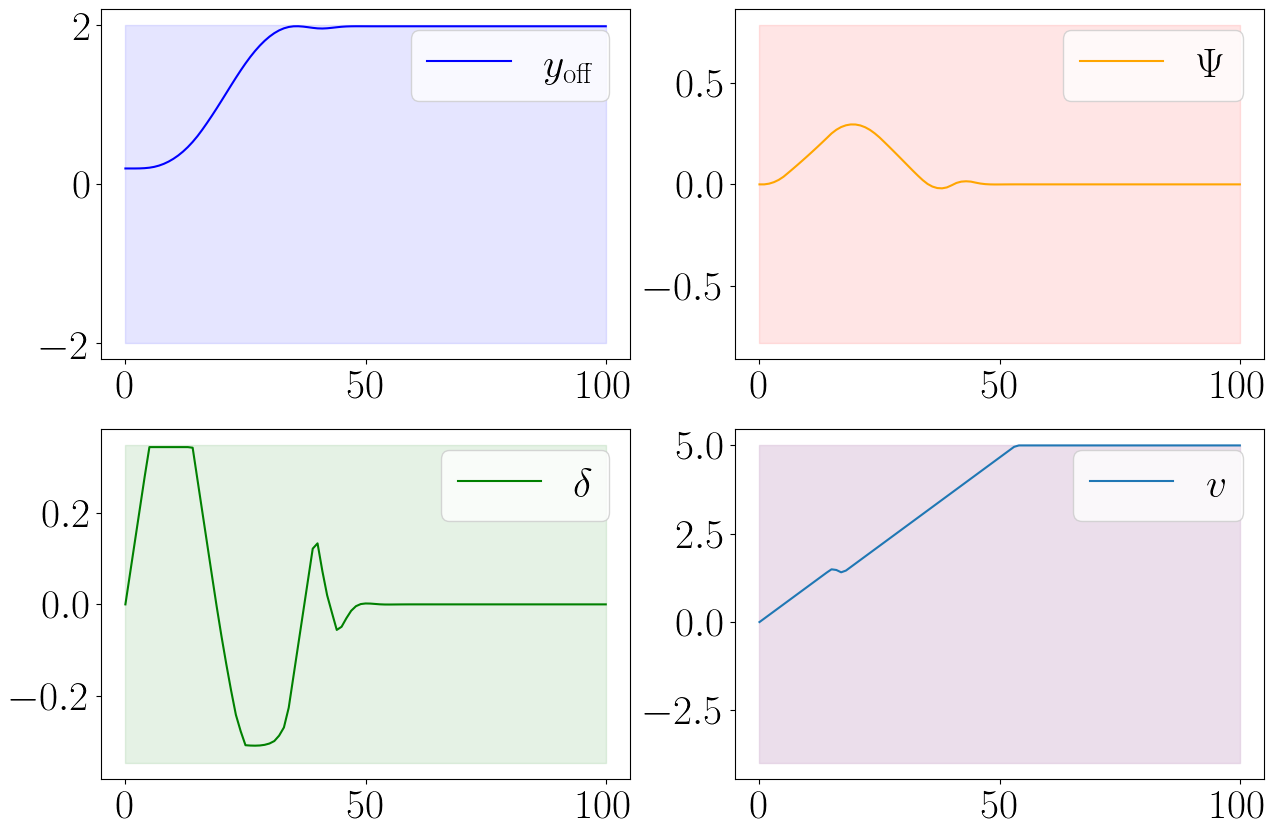

In [37]:
t = np.arange(N_steps+1)
fig, axs = plt.subplots(2,2)
axs[0][0].plot(t,x_safe[:,0], label = '$y_{\mathrm{off}}$', color='blue')
axs[0][1].plot(t,x_safe[:,1], label = '$\Psi$', color='orange')
axs[1][0].plot(t,x_safe[:,2], label = '$\delta$', color='green')
axs[1][1].plot(t,x_safe[:,3], label = '$v$')

y = np.zeros_like(t)
axs[0, 0].fill_between(t, (y-X.b[1]), (y+X.b[0]), color='b', alpha=.1)
axs[0, 1].fill_between(t, (y-X.b[3]), (y+X.b[2]), color='red', alpha=.1)
axs[1, 0].fill_between(t, (y-X.b[5]), (y+X.b[4]), color='green', alpha=.1)
axs[1, 1].fill_between(t, (y-X.b[7]), (y+X.b[6]), color='thistle', alpha=.5)   


axs[0,0].legend()
axs[0,1].legend()
axs[1,0].legend()
axs[1,1].legend()

In [38]:
u_p_traj_1 = []
u_p_traj_2 = []
for x in x_safe :
    u_p_traj_1.append(bad_ctrl.input(x)[0])
    u_p_traj_2.append(bad_ctrl.input(x)[1])
u_p_traj_1[-2]
u_p_traj_2[-2]

69.83489514289337

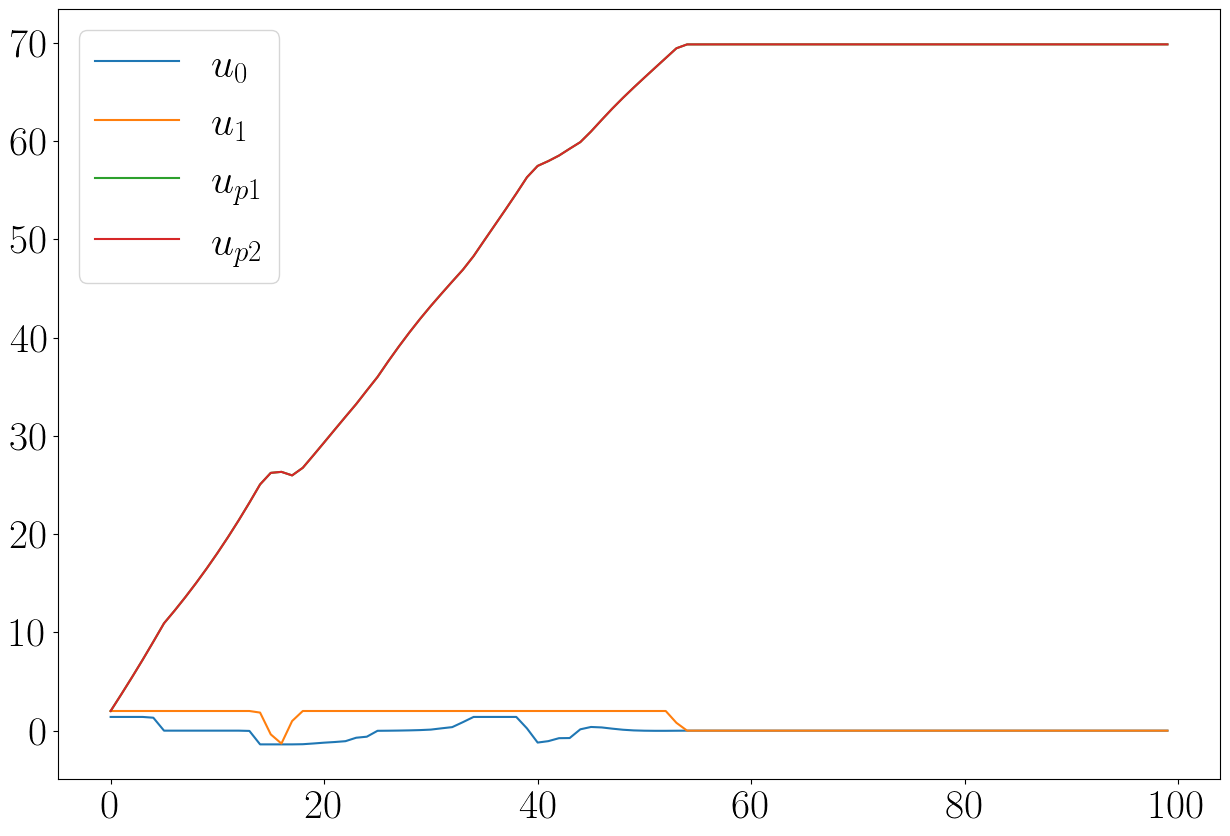

In [39]:
# Plot inputs applied to system vs performance controller inputs
t = np.arange(N_steps)
plt.plot(t,u_safe[:,0], label = '$u_0$')
plt.plot(t,u_safe[:,1], label = '$u_1$')
plt.plot(t, u_p_traj_1[:-1], label = '$u_{p1}$')
plt.plot(t, u_p_traj_2[:-1], label = '$u_{p2}$')

plt.legend()

In [40]:
print(u_safe.max())
print(u_safe.min())

2.000000018705638
-1.3962634155275406


### Multiple ICs Simulation

Set $\delta=0, v=0$

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:157:
.../casadi/core/optistack_internal.cpp:998: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Infeasible_Problem_Detected'
0.0 0.0
Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:157:
.../casadi/core/optistack_internal.cpp:998: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Maximum_Iterations_Exceeded'
2.25 0.0


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:157:
.../casadi/core/optistack_internal.cpp:998: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Maximum_Iterations_Exceeded'
-4.5 0.4
Number of infeasible/failure points : 3


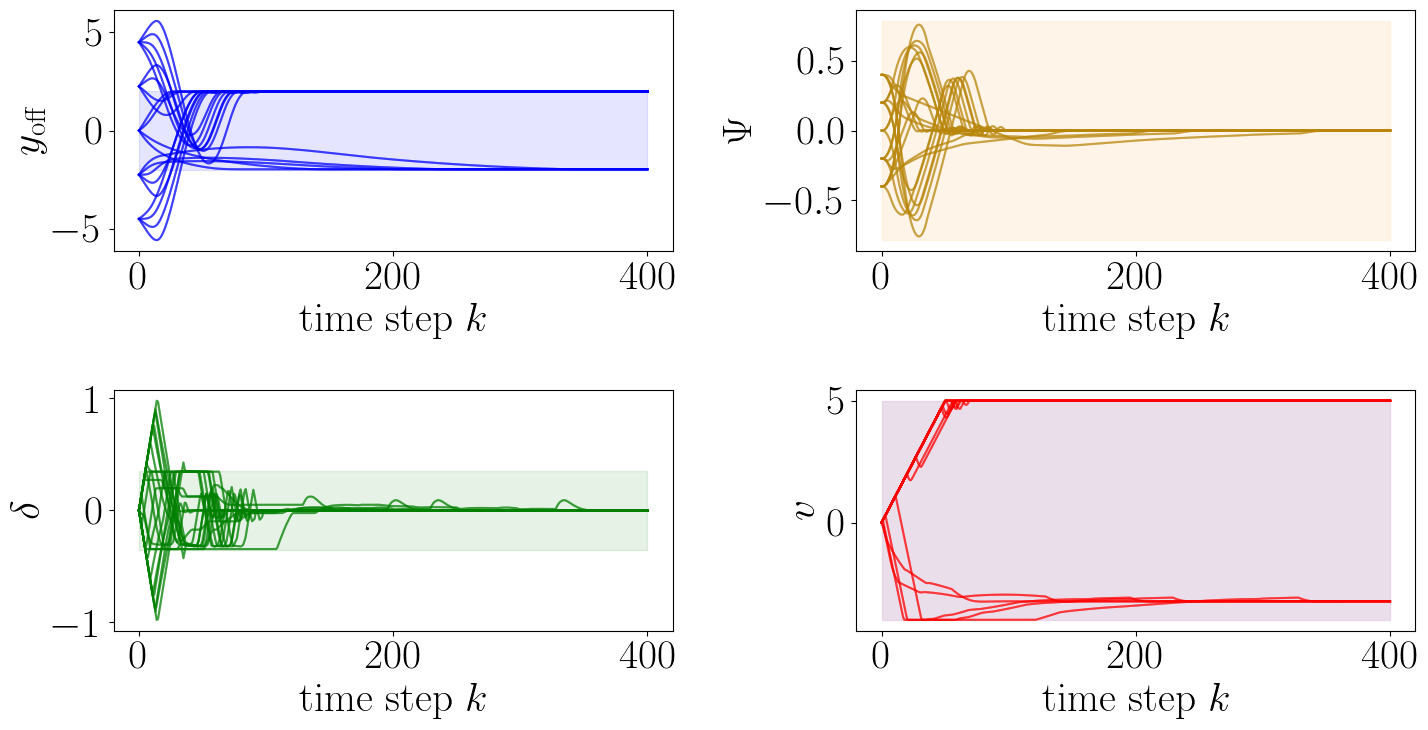

In [49]:
from tqdm.notebook import tqdm
#%matplotlib widget
n_points = 5
x1 = np.linspace(-4.5,4.5,n_points)
x2 = np.linspace(-0.4,0.4,n_points)
x1,x2 = np.meshgrid(x1,x2)
algo =  AlgorithmNonlinear(non_lin_disc, bad_ctrl, X, U, delta_i, param_dict=param_dict, verbose=False)
hpb = np.zeros((len(x1), len(x2)))

numb_infeasible = 0
failure_pts = []
h_traj = []

Nsteps = 400

t = np.arange(Nsteps+1)
y = np.zeros_like(t)
fig, axs = plt.subplots(2,2)

#plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.2)



axs[0, 0].set(ylabel = '$y_{\mathrm{off}}$')
axs[0, 1].set(ylabel = '$\Psi$')
axs[1, 0].set(ylabel = '$\delta$')
axs[1, 1].set(ylabel = '$v$')

axs[0, 0].set(xlabel = 'time step $k$')
axs[0, 1].set(xlabel = 'time step $k$')
axs[1, 0].set(xlabel = 'time step $k$')
axs[1, 1].set(xlabel = 'time step $k$')

axs[0, 0].fill_between(t, (y-X.b[1]), (y+X.b[0]), color='blue', alpha=.1)
axs[0, 1].fill_between(t, (y-X.b[3]), (y+X.b[2]), color='bisque', alpha=.4)
axs[1, 0].fill_between(t, (y-X.b[5]), (y+X.b[4]), color='green', alpha=.1)
axs[1, 1].fill_between(t, (y-X.b[7]), (y+X.b[6]), color='thistle', alpha=.5)      

x_plot = []
u_plot = []

for j in tqdm(range(len(x1))):
    for k in tqdm(range(len(x2)), leave = False):
        try :
            x_safe, u_safe = sim.simulate_discrete(np.array([x1[j,k], x2[j,k], 0, 0]), non_lin_disc, controller_object=algo, Nsteps=Nsteps, verbose=False)
            # Check if terminal state has reached constraints otherwise don't plot
            #if np.all(X.A @ x_safe[-1,:] <= X.b) :
            # Check if are in domain D_BP
            #if algo.hpb_traj[0] < gamma_f*alpha_f :
            
            x_plot.append(x_safe)
            u_plot.append(u_safe)
            
            
            #axs[0][0].plot(t,x_safe[:,0], label = '$y_{\mathrm{off}}$', color='blue', alpha=.5)
            #axs[0][1].plot(t,x_safe[:,1], label = '$\Psi$', color='darkgoldenrod', alpha=.5)
            #axs[1][0].plot(t,x_safe[:,2], label = '$\delta$', color='green', alpha=.5)
            #axs[1][1].plot(t,x_safe[:,3], label = '$v$',  color='red', alpha=.5)


            hpb[j,k] = algo.hpb_traj[0]
            h_traj.append(algo.hpb_traj)
            algo.reset()
        except Exception as e:
            print(e)
            algo.reset()
            numb_infeasible += 1
            x_failure = x1[j,k], x2[j,k]
            print(x1[j,k], x2[j,k])
            failure_pts.append(np.array([x1[j,k], x2[j,k]])) 



#axs[0,0].legend()
#axs[0,1].legend()
#axs[1,0].legend()
#axs[1,1].legend()

if numb_infeasible > 0 :
    print(f"Number of infeasible/failure points : {numb_infeasible}")
#trajectories = [sim.simulate_discrete(np.array([x1,x2]), lin_sys, controller_object=algo, Nsteps=N_steps) for x1,x2 in zip(x1,x2)]
#if save_fig :
for i in range(len(x_plot)):
    axs[0][0].plot(t,x_plot[i][:,0], label = '$y_{\mathrm{off}}$', color='blue', alpha=.5)
    axs[0][1].plot(t,x_plot[i][:,1], label = '$\Psi$', color='darkgoldenrod', alpha=.5)
    axs[1][0].plot(t,x_plot[i][:,2], label = '$\delta$', color='green', alpha=.5)
    axs[1][1].plot(t,x_plot[i][:,3], label = '$v$',  color='red', alpha=.5)

plt.tight_layout()
#plt.savefig(f'plots/pdf/nonlin_trajectories__nonlinear_pcbf_sfmpc_box2_{n_points}pts.pdf', bbox_inches='tight')

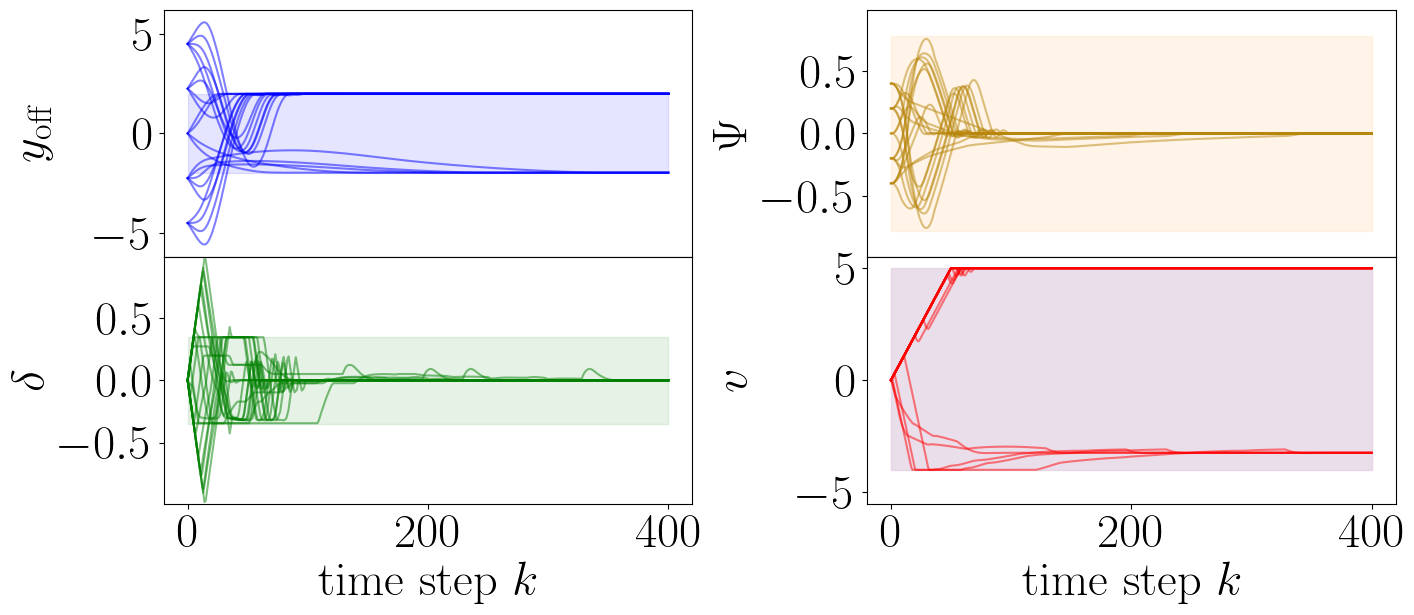

In [63]:
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 35})
plt.rc('text', usetex=True)
plt.rcParams['figure.figsize'] = [15, 7]

t = np.arange(Nsteps+1)
y = np.zeros_like(t)
fig, axs = plt.subplots(2,2)
axs[0, 0].set(ylabel = '$y_{\mathrm{off}}$')
axs[0, 1].set(ylabel = '$\Psi$')
axs[1, 0].set(ylabel = '$\delta$')
axs[1, 1].set(ylabel = '$v$')

axs[0, 0].set(xlabel = 'time step $k$')
axs[0, 1].set(xlabel = 'time step $k$')
axs[1, 0].set(xlabel = 'time step $k$')
axs[1, 1].set(xlabel = 'time step $k$')

axs[0, 0].fill_between(t, (y-X.b[1]), (y+X.b[0]), color='blue', alpha=.1)
axs[0, 1].fill_between(t, (y-X.b[3]), (y+X.b[2]), color='bisque', alpha=.4)
axs[1, 0].fill_between(t, (y-X.b[5]), (y+X.b[4]), color='green', alpha=.1)
axs[1, 1].fill_between(t, (y-X.b[7]), (y+X.b[6]), color='thistle', alpha=.5)     

for i in range(len(x_plot)):
    axs[0][0].plot(t,x_plot[i][:,0], label = '$y_{\mathrm{off}}$', color='blue', alpha=.5)
    axs[0][1].plot(t,x_plot[i][:,1], label = '$\Psi$', color='darkgoldenrod', alpha=.5)
    axs[1][0].plot(t,x_plot[i][:,2], label = '$\delta$', color='green', alpha=.5)
    axs[1][1].plot(t,x_plot[i][:,3], label = '$v$',  color='red', alpha=.5)

axs[0, 0].set_ylim([-6.2, 6.2])
axs[0, 1].set_ylim([-0.99, 0.99])
axs[1, 0].set_ylim([-0.99, 0.99])
axs[1, 1].set_ylim([-5.5, 5.5])


axs[0, 0].tick_params(axis='x', bottom=False, labelbottom=False)
axs[0, 1].tick_params(axis='x', bottom=False, labelbottom=False)

fig.align_ylabels(axs[:, 0])
fig.align_ylabels(axs[:, 1])

plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0.33)
plt.savefig(f'../plots/pdf/nonlin_trajectories__nonlinear_pcbf_sfmpc_box2_5pts.pdf', bbox_inches='tight')

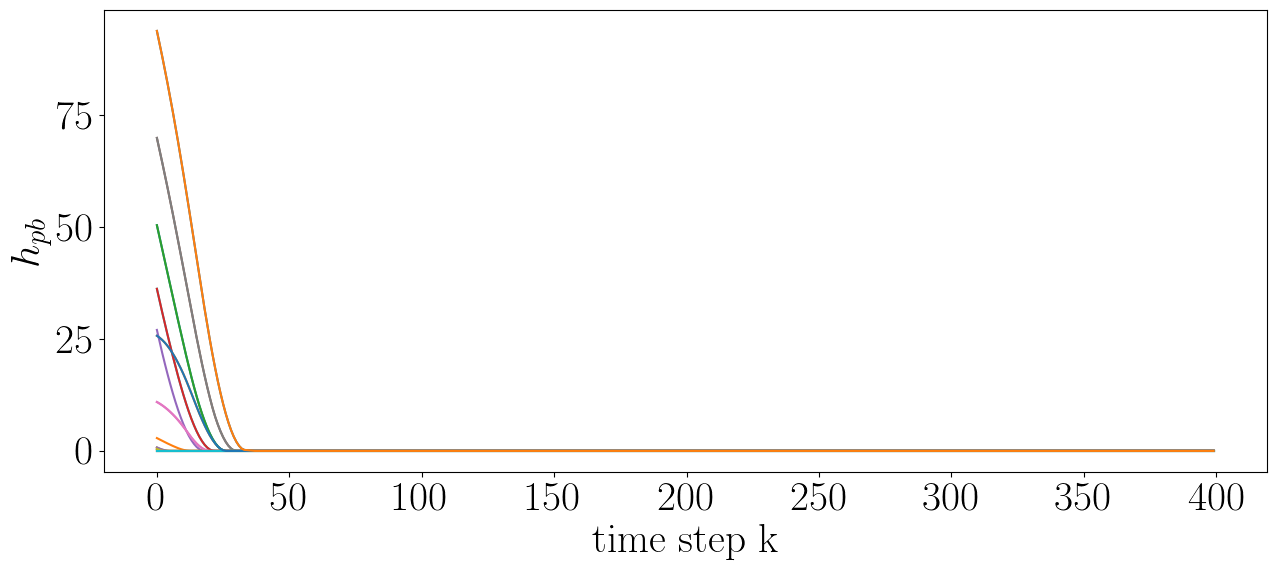

In [53]:
h_traj = np.array(h_traj)
from matplotlib.ticker import MaxNLocator
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size':30})
plt.rc('text', usetex=True)

ax = plt.figure().gca()

for i in range(len(h_traj)) :
    ax.plot(h_traj[i])
plt.xlabel('time step k')
plt.ylabel('$h_{pb}$')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#plt.grid()

#if save_fig :
#plt.savefig(f'plots/pdf/nolinear_multiple_hbp_traj_function_of_steps.pdf', bbox_inches='tight')

### Plotting  $h_{\mathrm{PB}}$ contour (where $\delta(0) = v(0) = 0 $)

In [ ]:
from tqdm.notebook import tqdm
#%matplotlib widget
n_points = 30 # number of points per dimension
x1 = np.linspace(-2.3,2.3,n_points)
x2 = np.linspace(-2,2,n_points)
x1,x2 = np.meshgrid(x1,x2)
pcbf =  NONLINEAR_PCBF_OPT(non_lin_cont, X, U, delta_i, param_dict, N=50)
hpb = np.zeros((len(x1), len(x2)))
h_ind = np.zeros((len(x1), len(x2)))
#x_safe, u_safe = sim.simulate_discrete(x0, lin_sys, controller_object=algo, Nsteps=N_steps)

numb_infeasible = 0
failure_pts = []

for j in tqdm(range(len(x1))):
    for k in tqdm(range(len(x2)), leave = False):
        _, _, hpb[j,k], _ ,  _ = pcbf.solve(np.array([x1[j,k],x2[j,k], 0, 0])) #compute true cbf
        if hpb[j,k] < 0.001 :
            h_ind[j,k] = 1


In [ ]:
Hx_2_states = np.kron(np.eye(2),np.array([[1],[-1]]))
hx_2_states = np.ones((2*2,1))
hx_2_states[:2] = 2
hx_2_states[2:] = np.pi/4
X_2_states = Polytope(Hx_2_states, hx_2_states)

In [ ]:
plt.contour(x1, x2, hpb, levels = 80)#, vmax=1.2)
X_2_states.plot(facecolor='red', alpha=0.3, edgecolor='black', color=constraint_color, linewidth=3.0, zorder=100)
plt.grid()
plt.xlabel('$y_{off}$')#, fontsize=12)
plt.ylabel('$\Psi$')
plt.axis('square')
#cs_sf = plt.contour(x1,x2,h_ind,[0.9])
#if save_fig :
#plt.savefig(f'plots/pdf/non_lin_h_pb_contour_and_constraints_lines_square_gamma_x={gamma_x}_{n_points}_pts_vmax_1pt_2.pdf')

In [ ]:
# Plot the safe set S_PB
from matplotlib.patches import Rectangle
fig, ax = plt.subplots()
CS = ax.contourf(x1,x2, h_ind, levels=[0,.9])
#X_2_states.plot(facecolor='red', alpha=0.1, edgecolor='black', color=constraint_color, linewidth=3.0, zorder=100)

ax.add_patch( Rectangle((-2, -np.pi/2),
                        4, 2*np.pi/2,
                        fc ='none', 
                        ec ='g',
                        lw = 10))
#fig.colorbar(CS, ax=ax)
#plt.savefig(f'plots/pdf/S_pb_non_linear_gamma_x={gamma_x}.pdf')
plt.show()